# import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import math

# Calculate mel-scale frequencies

In [2]:
def mel2freq(m: float) -> float:
    return 700*(np.e**(m/1127) - 1)

In [3]:
def freq2mel(freq: float) -> float:
    return 1127*np.log(1+freq/700)

In [4]:
def getFreq(start: float, stop: float, num: int) -> list:
    """Given a start and a stop frequency, get a list of frequencies 
    evenly spaced on a mel-scale"""
    # get evenly distributed mel-scale data points
    melData = np.linspace(freq2mel(start), freq2mel(stop), num=num)
    # mel-scale to frequency
    return np.array([mel2freq(x) for x in melData])

In [5]:
freq = getFreq(100, 4000, 10)
freq

array([ 100.        ,  273.94695916,  485.71584908,  743.53043206,
       1057.40259345, 1439.5211399 , 1904.72513534, 2471.08015627,
       3160.57984434, 4000.        ])

# Get transfer functions

## Get range of Q

$Q \geq \sqrt{(\frac{1}{x^{2}}-1)(\frac{ff_{0}}{f_{0}^{2}-f^{2}})^{2}}$

$20\lg x=-10dB$

In [6]:
def getQmin(f0: float, f: float) -> float:
    """Get Q lower limit"""
    # get x value
    x = 10**(-0.5)
    # get lower limit of Q
    return np.sqrt((1/(x**2)-1)*(((f0*f)/(f0**2-f**2))**2))

In [7]:
flower = np.hstack((np.array([0]), freq[:-1]))
flower

array([   0.        ,  100.        ,  273.94695916,  485.71584908,
        743.53043206, 1057.40259345, 1439.5211399 , 1904.72513534,
       2471.08015627, 3160.57984434])

In [8]:
fupper = np.hstack((freq[1:], np.array([5021.938386])))
fupper

array([ 273.94695916,  485.71584908,  743.53043206, 1057.40259345,
       1439.5211399 , 1904.72513534, 2471.08015627, 3160.57984434,
       4000.        , 5021.938386  ])

In [9]:
Qlowermin = []
Quppermin = []
Qmin = []
for i, value in enumerate(freq):
    if i == 0:
        ql = 0
    else:
        ql = getQmin(value, flower[i])
    qn = getQmin(value, fupper[i])
    q = max(ql, qn)
    Qlowermin.append(ql)
    Quppermin.append(qn)
    Qmin.append(q)

## Get transfer function coefficients

Transfer function of bandpass filter $H(s) = \frac{\frac{w_{0}}{Q}s}{s^{2}+s\frac{w_{0}}{Q}+w_{0}^{2}}$

In [10]:
def getCoeff(f: float, Q: float) -> list:
    """Get coefficients of numerator and denominator"""
    w0 = 2*np.pi*f
    return [[0, w0/Q, 0], [1, w0/Q, w0**2]]

In [11]:
data = []
for i in range(len(freq)):
    if round(Qmin[i])>Qmin[i]:
        Qtarget = round(Qmin[i])
    else:
        Qtarget = round(Qmin[i])+1
    Coefficient = getCoeff(freq[i], Qtarget)
    # print("No.{} filter, Qtarget = {}, Qmin = {}, Coefficient = {}".format(i+1, Qtarget, Qmin[i], Coefficient))
    data.append([i + 1, freq2mel(freq[i]), freq[i], flower[i], fupper[i], Qlowermin[i], 
                 Quppermin[i], Qmin[i], Qtarget, Coefficient])
df = pd.DataFrame(data, columns=['No.', 'm', 'f0', 'fl, lower bandpass edge', 'fu, upper bandpass edge', 
                           'Qlmin', 'Qumin', 'Qmin', 'Qtarget', 'numerator and denominator'])

In [12]:
df

,No.,m,f0,"fl, lower bandpass edge","fu, upper bandpass edge",Qlmin,Qumin,Qmin,Qtarget,numerator and denominator
0,1,150.489879,100.000000,0.000000,273.946959,0.000000,1.263458,1.263458,2,"[[0, 314.15926535897916, 0], [1, 314.159265358..."
1,2,372.221627,273.946959,100.000000,485.715849,1.263458,2.481344,2.481344,3,"[[0, 573.7531695882245, 0], [1, 573.7531695882..."
2,3,593.953375,485.715849,273.946959,743.530432,2.481344,3.418660,3.418660,4,"[[0, 762.9606716018358, 0], [1, 762.9606716018..."
3,4,815.685123,743.530432,485.715849,1057.402593,3.418660,4.172631,4.172631,5,"[[0, 934.3478972263734, 0], [1, 934.3478972263..."
4,5,1037.416870,1057.402593,743.530432,1439.521140,4.172631,4.786039,4.786039,5,"[[0, 1328.7712877891013, 0], [1, 1328.77128778..."
5,6,1259.148618,1439.521140,1057.402593,1904.725135,4.786039,5.287251,5.287251,6,"[[0, 1507.4630125968085, 0], [1, 1507.46301259..."
6,7,1480.880366,1904.725135,1439.521140,2471.080156,5.287251,5.697622,5.697622,6,"[[0, 1994.6234974283973, 0], [1, 1994.62349742..."
7,8,1702.612114,2471.080156,1904.725135,3160.579844,5.697622,6.033987,6.033987,7,"[[0, 2218.036361538449, 0], [1, 2218.036361538..."
8,9,1924.343861,3160.579844,2471.080156,4000.000000,6.033987,6.309870,6.309870,7,"[[0, 2836.9298342997995, 0], [1, 2836.92983429..."
9,10,2146.075609,4000.000000,3160.579844,5021.938386,6.309870,6.536241,6.536241,7,"[[0, 3590.3916041026205, 0], [1, 3590.39160410..."


## Using quality factor, natural frequency, and gain

In [13]:
def plotBandpassFilter(Q: float, f0: float, flower: float, fupper: float, index: int, fstart=10, fend=5e4, mode='freq'):
    """
    Plot the frequency response of the filter.
    
    Coeff: numerator and denominator of the transfer function
    Q: quality factor
    f0: center frequency
    flower: center frequency of last filter
    fupper: center frequency of next filter
    index: index of the filter in the filter bank
    fstart: start frequency of frequency response
    fend: end frequency of frequency response
    mode: set x-axis to frequency or mel
    """
    # Get transfer function
    num, denom = getCoeff(f0, Q)
    sys = signal.TransferFunction(num, denom)

    # Frequency response
    w, mag, phase = signal.bode(sys, w=np.linspace(2*np.pi*fstart, 2*np.pi*fend, num=int(2*np.pi*(fend-fstart+1))))
    w = [x/(2*np.pi) for x in w]
    if mode == 'mel':
        w = [freq2mel(x) for x in w]
    # Plot the frequency response
    plt.figure()
    if mode == 'mel':
        plt.plot(w, mag)    # Bode magnitude plot
        plt.axvline(x=freq2mel(flower), color='r')
        plt.axvline(x=freq2mel(fupper), color='r')
    else:
        plt.semilogx(w, mag)    # Bode magnitude plot
        plt.axvline(x=flower, color='r')
        plt.axvline(x=fupper, color='r')
    plt.axhline(y=-10, color='r')
    plt.title('Magnitude Response of Bandpass Filter {}, f0 = {}Hz, Q = {}'.format(index, 
                round(f0, 3), round(Q, 3)))
    if mode == 'mel':
        plt.xlabel('Mel')
        plt.xlim([freq2mel(flower*0.9), freq2mel(fupper*1.1)])
    else:
        plt.xlabel('Frequency [Hz]')
        plt.xlim([flower*0.9, fupper*1.1])
    plt.ylabel('Amplitude [dB]')
    plt.ylim([-15, 0])
    plt.grid(which='both', axis='both')
    
    plt.figure()
    plt.semilogx(w, phase)  # Bode phase plot
    plt.title('Phase Response of Bandpass Filter {}, f0 = {}Hz, Q = {}'.format(index, 
                round(f0, 3), round(Q, 3)))
    if mode == 'mel':
        plt.xlabel('Mel')
        plt.xlim([freq2mel(fstart), freq2mel(fend)])
    else:
        plt.xlabel('Frequency [Hz]')
        plt.xlim([fstart, fend])
    plt.ylabel('Phase [deg]')
    plt.ylim([-100, 100])
    plt.grid(which='both', axis='both')
    
    plt.show()

D:\Python\Python39\install\lib\site-packages\scipy\signal\_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


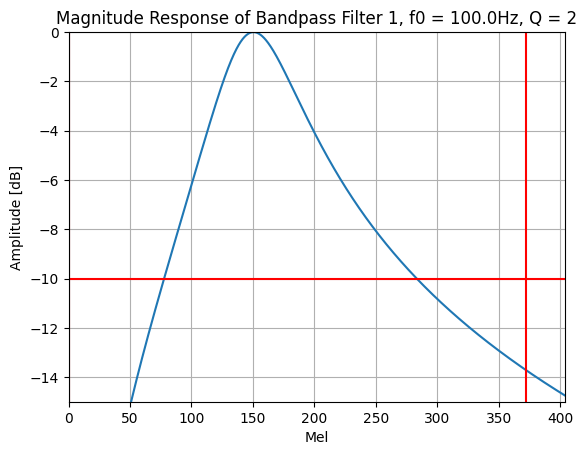

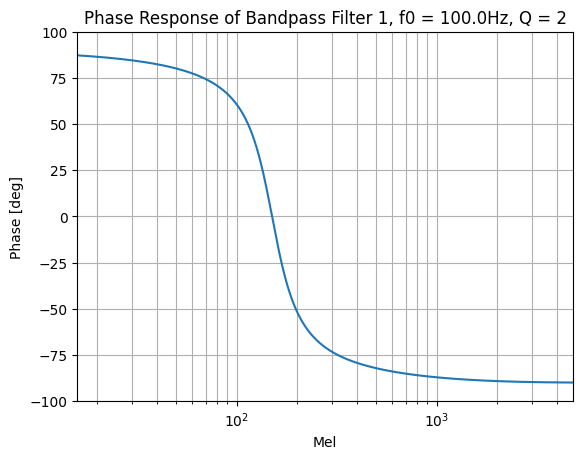

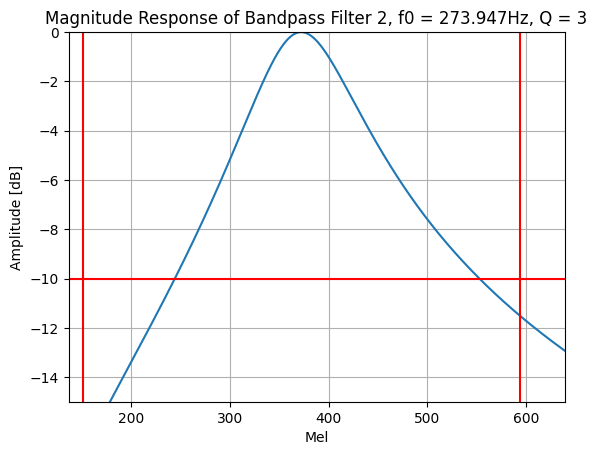

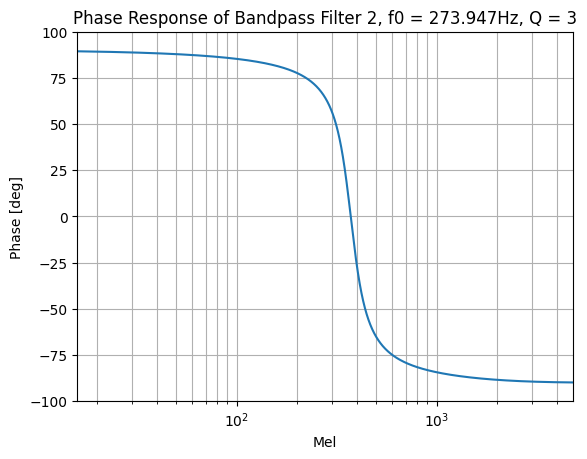

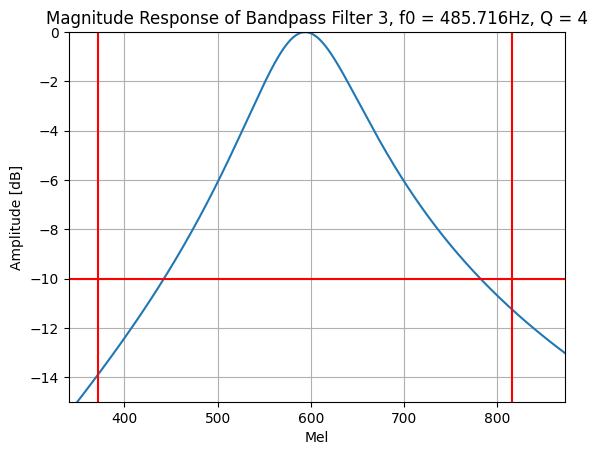

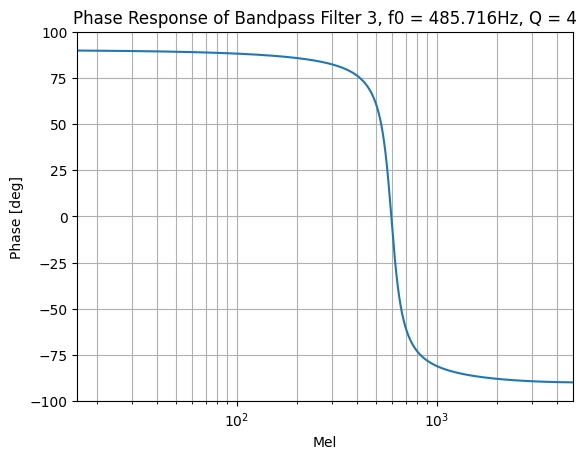

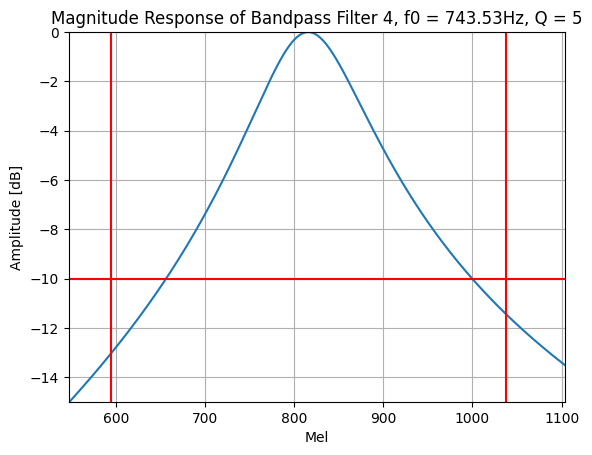

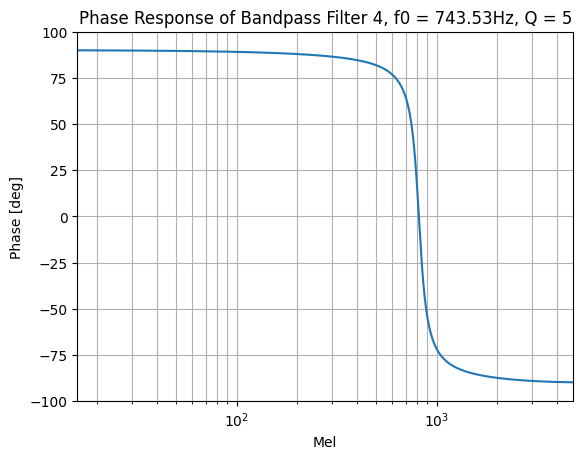

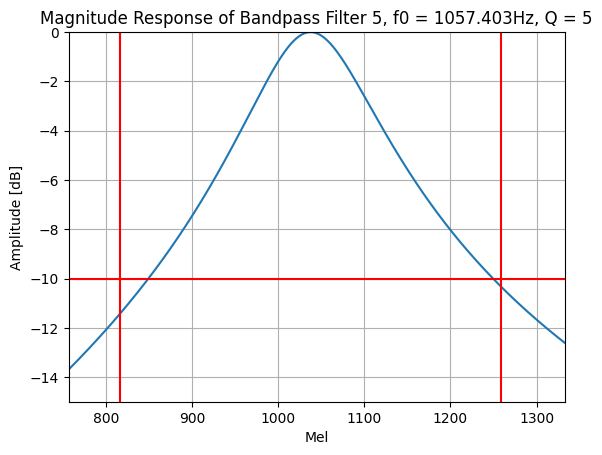

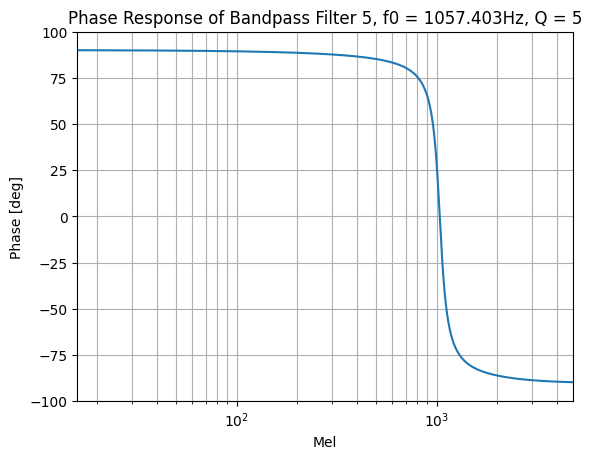

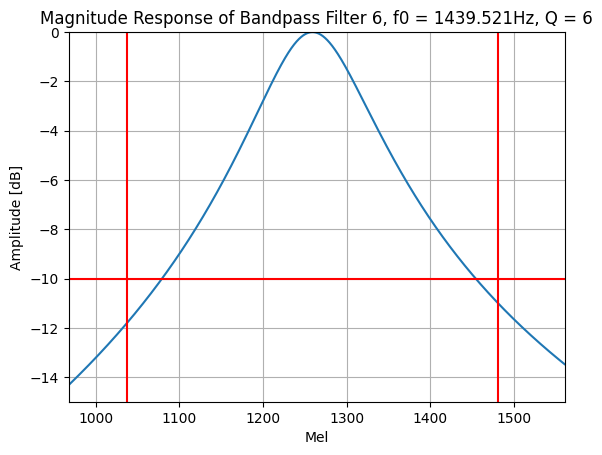

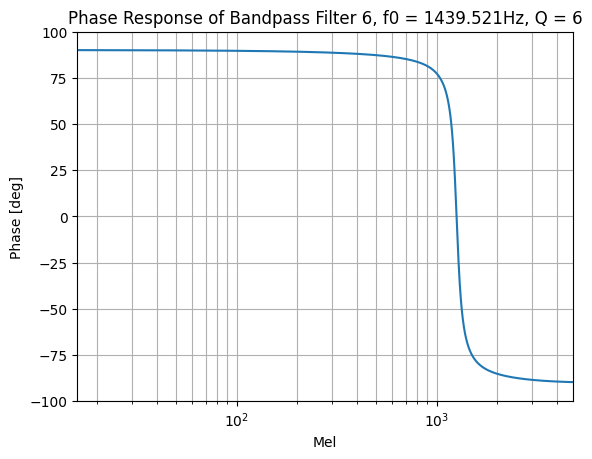

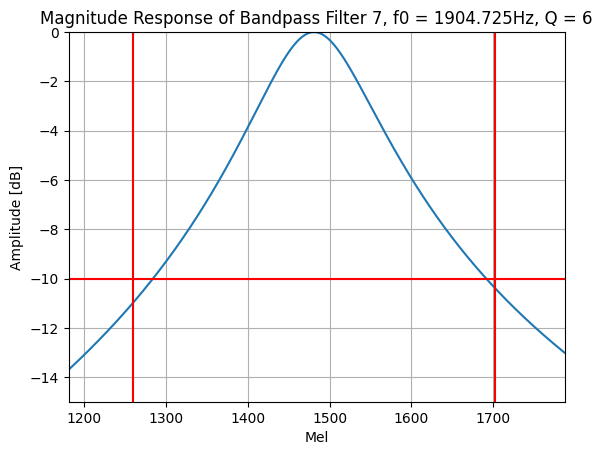

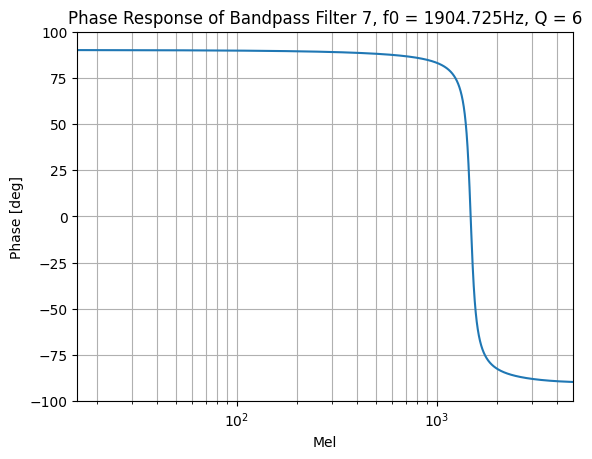

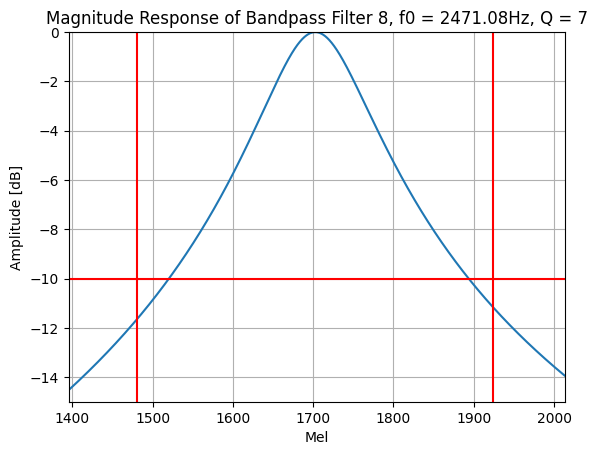

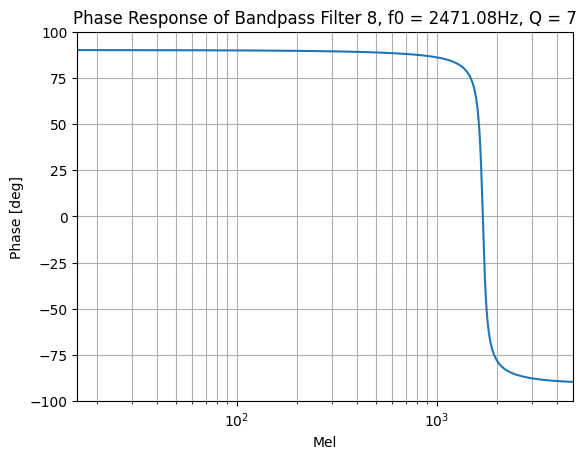

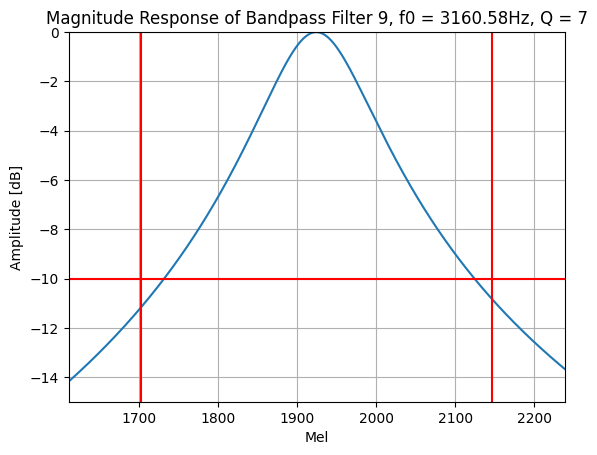

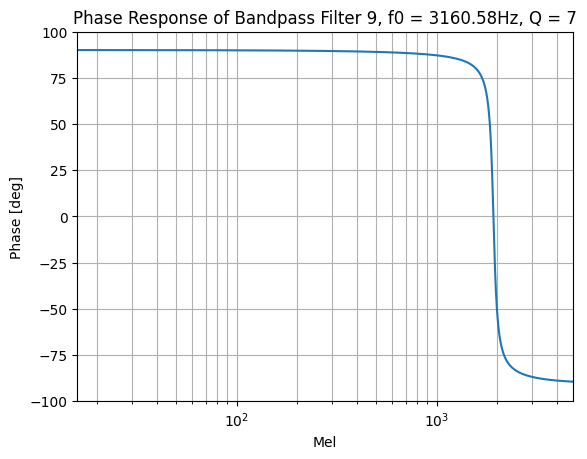

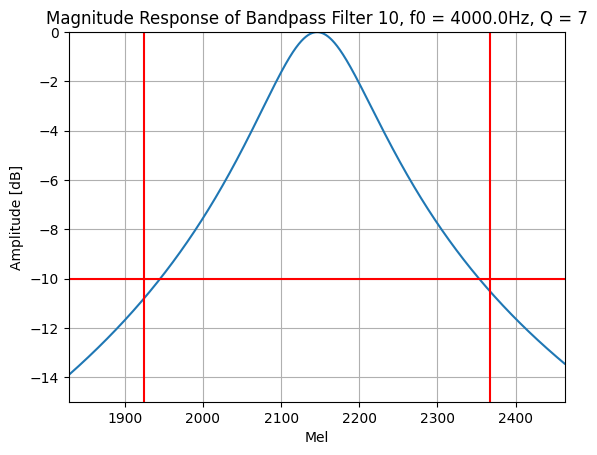

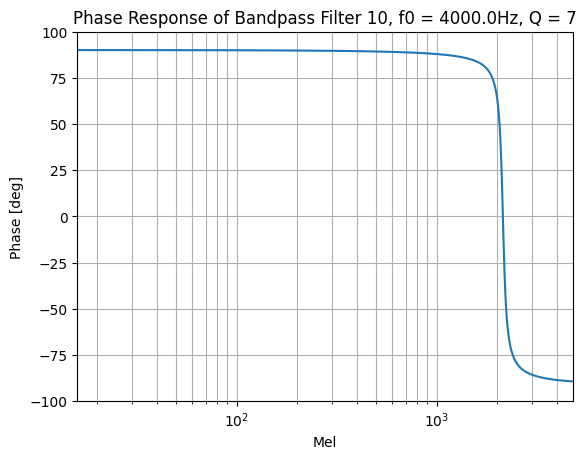

In [14]:
# get fiter data
for index in range(1, 11):
    Q = df.loc[index - 1, 'Qtarget'] # change this to another value for different design
    f0 = df.loc[index - 1, 'f0']
    flower = df.loc[index - 1, 'fl, lower bandpass edge']
    fupper = df.loc[index - 1, 'fu, upper bandpass edge']
    # plot frequency response
    plotBandpassFilter(Q, f0, flower, fupper, index, mode='mel')

C:\Users\wj\AppData\Local\Temp\ipykernel_13860\2212084858.py:42: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([flower*0.9, fupper*1.1])


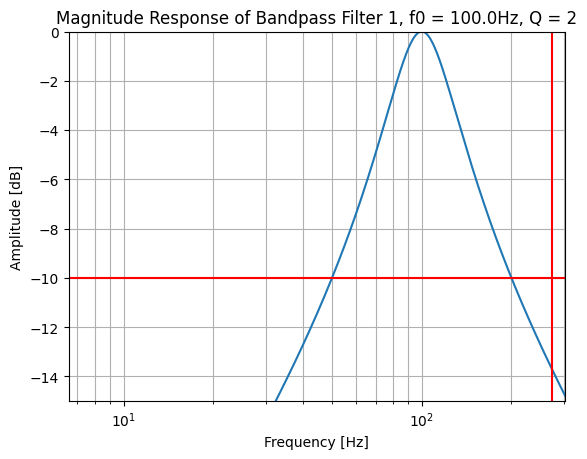

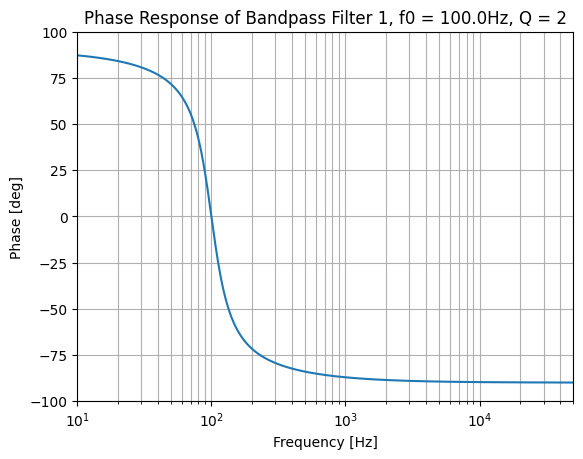

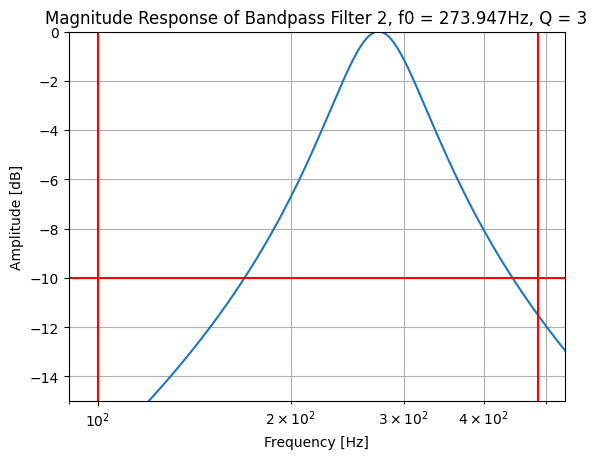

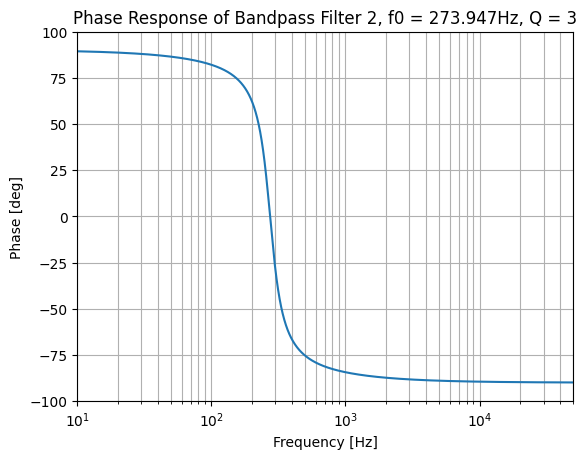

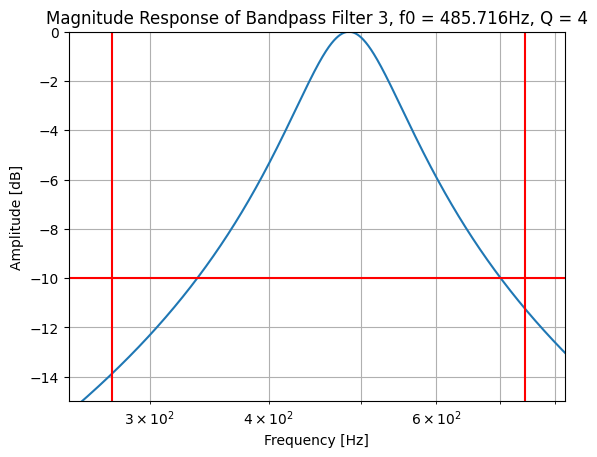

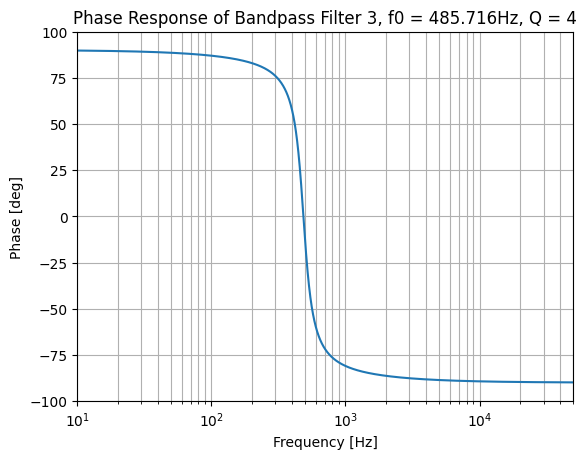

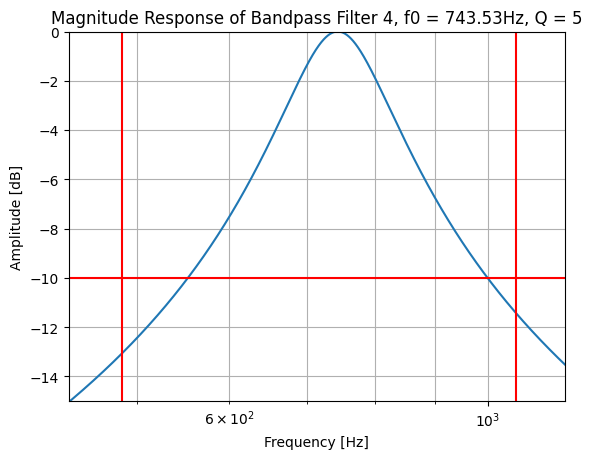

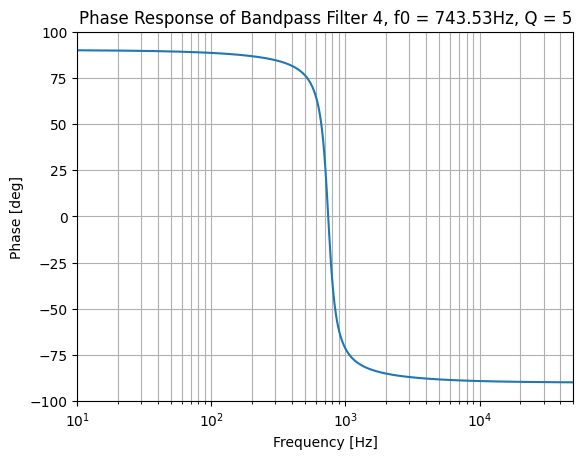

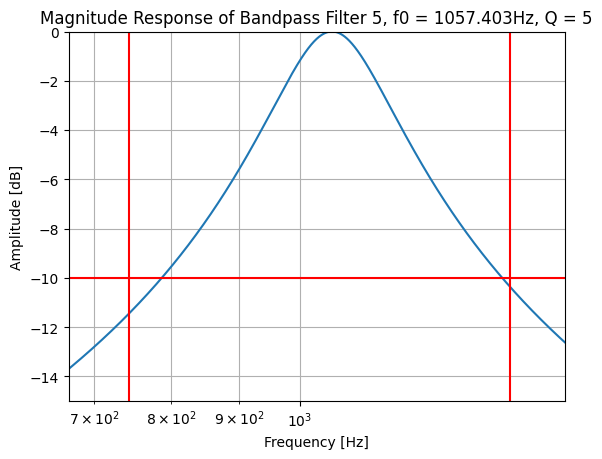

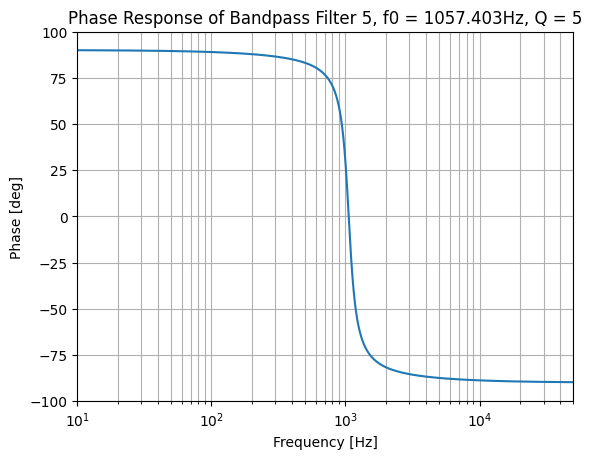

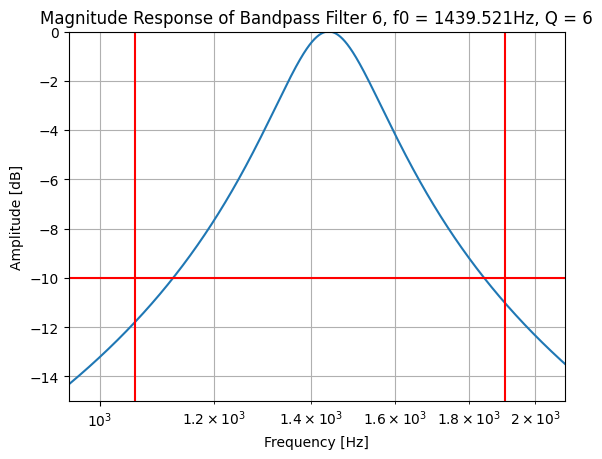

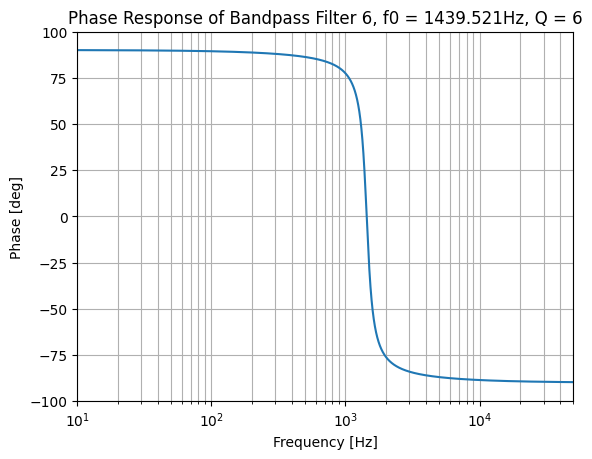

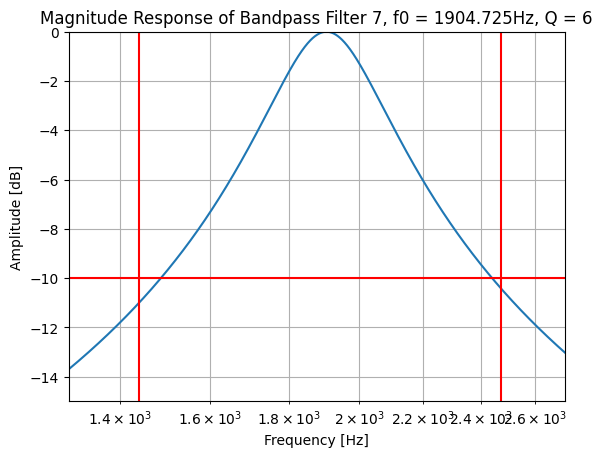

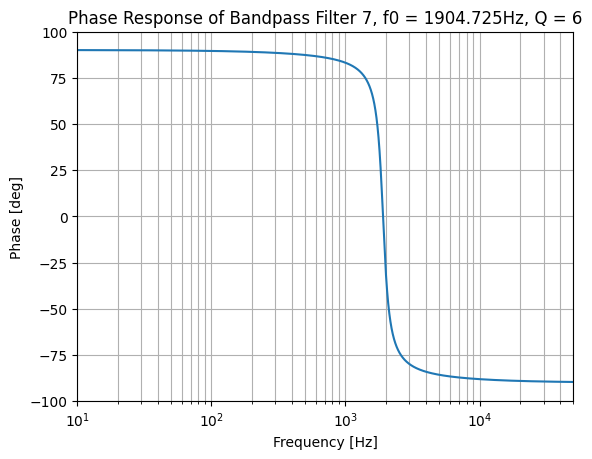

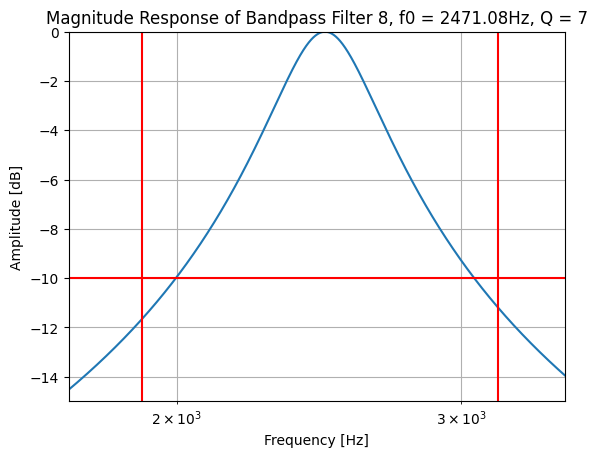

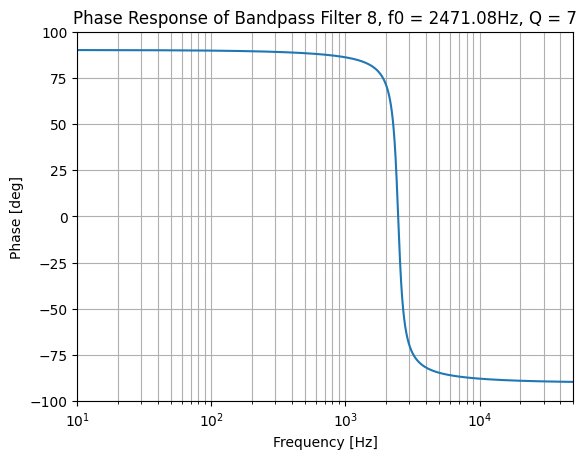

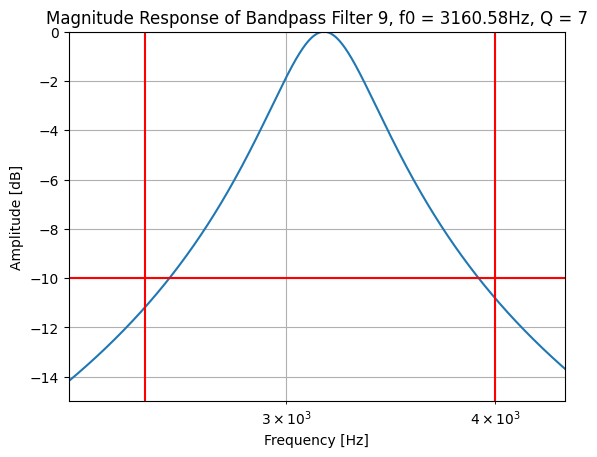

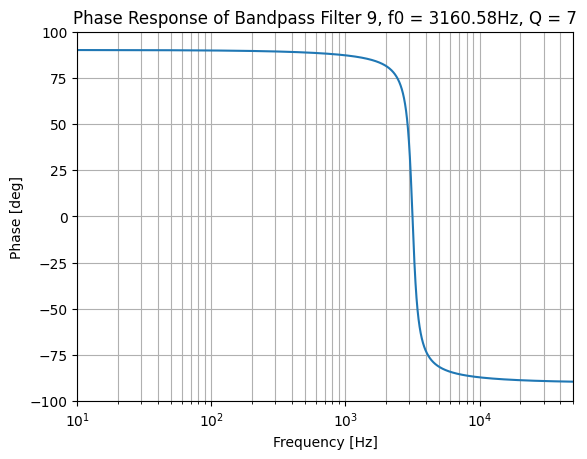

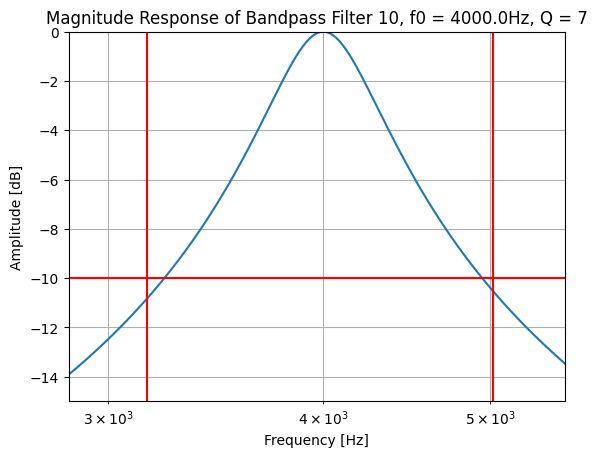

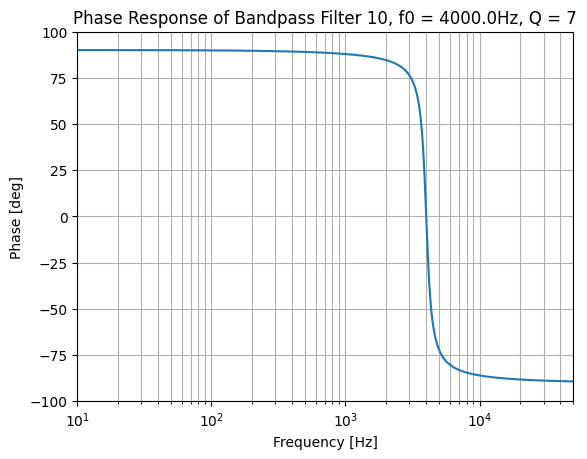

In [15]:
# get fiter data
for index in range(1, 11):
    Q = df.loc[index - 1, 'Qtarget'] # change this to another value for different design
    f0 = df.loc[index - 1, 'f0']
    flower = df.loc[index - 1, 'fl, lower bandpass edge']
    fupper = df.loc[index - 1, 'fu, upper bandpass edge']
    # plot frequency response
    plotBandpassFilter(Q, f0, flower, fupper, index, mode='freq')

## Plot all frequency respond together

In [16]:
def plotAll(Q: list, f0: list, fstart=10, fend=1e4, mode='freq'):
    """
    Plot the frequency response of the filter.
    
    Coeff: numerator and denominator of the transfer function
    Q: quality factor
    f0: center frequency
    flower: center frequency of last filter
    fupper: center frequency of next filter
    index: index of the filter in the filter bank
    fend: end frequency of frequency response
    """
    # get coefficients
    Coeff = [getCoeff(f0[i], Q[i]) for i in range(len(f0))]
    # start plot
    plt.figure()
    for i in range(len(f0)):
        # Get transfer function
        num, denom = Coeff[i]
        sys = signal.TransferFunction(num, denom)
    
        # Frequency response
        w, mag, phase = signal.bode(sys, w=np.linspace(2*np.pi*fstart, 2*np.pi*fend, num=int(2*np.pi*(fend-fstart+1))))
        w = [x/(2*np.pi) for x in w]
        if mode == 'mel':
            w = [freq2mel(x) for x in w]
            plt.plot(w, mag)    # Bode magnitude plot
            # plt.axvline(x=freq2mel(f0[i]), color='k')
        else:
            plt.semilogx(w, mag)    # Bode magnitude plot
            # plt.axvline(x=f0[i], color='k')
    plt.title('Magnitude Response of Bandpass Filter Bank')
    if mode ==  'mel':
        plt.xlabel('Mel')
        plt.xlim([freq2mel(fstart), freq2mel(fend)])
    else:
        plt.xlabel('Frequency [Hz]')
        plt.xlim([fstart, fend])
    plt.ylabel('Amplitude [dB]')
    plt.ylim([-15, 0])
    plt.grid(which='both', axis='both')
    plt.axhline(y=-10, color='r')
    plt.show()

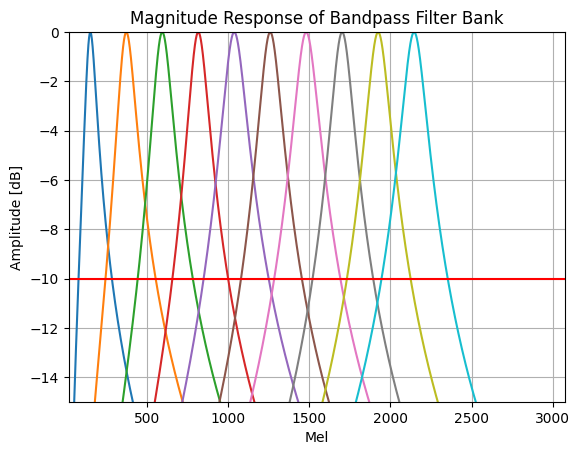

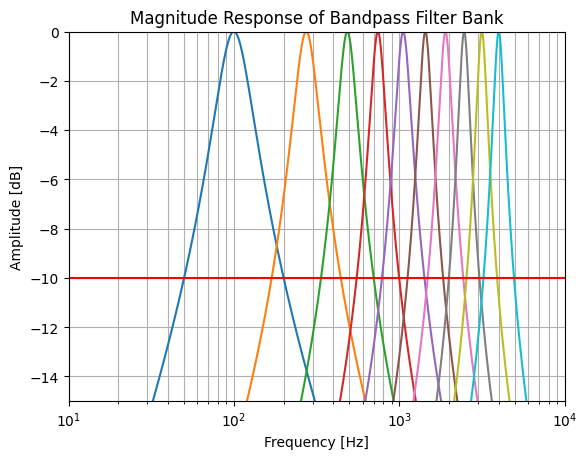

In [17]:
Q = list(df.loc[:, 'Qtarget']) # change to other values for different design
f0 = list(df.loc[:, 'f0'])
plotAll(Q, f0, mode='mel')
plotAll(Q, f0, mode='freq')

# Choose a possible component values

build a function for a single filter, which takes the value of capacitor and find the closest R value that satisfy $\omega_{0}$, unity gain, and $Q_{min}$ constraints

<img src="./cap values.png" alt="capacitor values" />

<img src="./Delyiannis.jpg" alt="Delyiannis" />

$H(s) = - \frac{s\frac{aG_{4}}{C}}{s^{2}+s\frac{2G_{3}}{C}+\frac{G_{3}G_{4}}{C^{2}}} = - \frac{sH_{B}\frac{\omega_{0}}{Q}}{s^{2} + s\frac{\omega_{0}}{Q} + \omega_{0}^{2}}$

$\omega_{0} = \frac{1}{C\sqrt{R_{3}R_{4}}}$

$Q = \frac{1}{2}\sqrt{\frac{G_{4}}{G_{3}}}$

$H_{B} =  2aQ^{2} = 1$

$R_{3} = \frac{2Q}{C\omega_{0}}$

$R_{4} = \frac{1}{2C\omega_{0}Q}$

$a = \frac{1}{2Q^{2}}$

In [18]:
Rcode =[1.00, 1.02, 1.05, 1.07, 1.10, 1.13, 1.15, 1.18, 1.21, 1.24, 1.27, 1.30, 1.33, 1.37, 1.40, 1.43, 
        1.47, 1.50, 1.54, 1.58, 1.62, 1.65, 1.69, 1.74, 1.78, 1.82, 1.87, 1.91, 1.96, 2.00, 2.05, 2.10,
        2.15, 2.21, 2.26, 2.32, 2.37, 2.43, 2.49, 2.55, 2.61, 2.67, 2.74, 2.80, 2.87, 2.94, 3.01, 3.09,
        3.16, 3.24, 3.32, 3.40, 3.48, 3.57, 3.65, 3.74, 3.83, 3.92, 4.02, 4.12, 4.22, 4.32, 4.42, 4.53, 
        4.64, 4.75, 4.87, 4.99, 5.11, 5.23, 5.36, 5.49, 5.62, 5.76, 5.90, 6.04, 6.19, 6.34, 6.49, 6.65, 
        6.81, 6.98, 7.15, 7.32, 7.50, 7.68, 7.87, 8.06, 8.25, 8.45, 8.66, 8.87, 9.09, 9.31, 9.53, 9.76]
Rfactor = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]) * 100

In [19]:
def getR(R: float, Rcode: list, Rfactor: list) -> float:
    """For a target R value, get the closest value"""
    # detect cornor case
    if R < Rcode[0] * Rfactor[0]:
        print("R value {} is too small!".format(R))
        return -1.0
    if R > Rcode[-1] * Rfactor[-1]:
        print("R value {} is too large!".format(R))
        return -1.0
    # get factor
    factor = math.floor(math.log(R, 10))
    # get normalized target R value
    normR = R/math.pow(10, factor)
    factorIndex = factor + 1
    # get code index
    codeIndLow = 0
    codeIndHigh = 0
    for i, value in enumerate(Rcode):
        if normR >= value:
            codeIndLow = i
        else:
            codeIndHigh = i
            break
    # calculate error
    if abs(normR - Rcode[codeIndLow]) <= abs(normR - Rcode[codeIndHigh]):
        Rtarget = Rcode[codeIndLow] * Rfactor[factorIndex]
    else:
        Rtarget = Rcode[codeIndHigh] * Rfactor[factorIndex]
    
    return Rtarget

In [20]:
# getR(10012, Rcode, Rfactor)

$R_{3} = \frac{2Q}{C\omega_{0}}$

$R_{4} = \frac{1}{2C\omega_{0}Q}$

$a = \frac{1}{2Q^{2}}$

In [21]:
def getComponents(C: int, Rcode: list, Rfactor: list, f0: float, Qtarget: float) -> list:
    """Take an input C value and all possible R values, return R3, R4, a values"""

    R3 = 2*Qtarget/(C*2*np.pi*f0)
    R4 = 1/(2*C*2*np.pi*f0*Qtarget)
    a = 1/(2*Qtarget*Qtarget)
    R41 = R4 * a
    R42 = R4 * (1 - a)
    # get closest R values
    R3 = getR(R3, Rcode, Rfactor)
    R41 = getR(R41, Rcode, Rfactor)
    R42 = getR(R42, Rcode, Rfactor)

    return [R3, R41, R42]

In [42]:
# get fiter data
R3data = []
R41data = []
R42data = []
Cdata = [0.1e-6, 1.5e-8, 1.5e-8, 8.2e-9, 4.7e-9, 4.7e-9, 4.7e-9, 1.2e-9, 1.2e-9, 1e-9]
for index in range(10):
    Q = df.loc[index, 'Qtarget'] # change this to another value for different design
    f0 = df.loc[index, 'f0']
    R3, R41, R42 = getComponents(Cdata[index], Rcode, Rfactor, f0, Q)
    if R3 < 0 or R41 < 0 or R42 < 0:
        print("Filter {} failed!".format(index + 1))
    R3data.append(R3)
    R41data.append(R41)
    R42data.append(R42)
# add data to df
df['R3'] = R3data
df['R41'] = R41data
df['R42'] = R42data
df['C'] = Cdata

In [43]:
df

,No.,m,f0,"fl, lower bandpass edge","fu, upper bandpass edge",Qlmin,Qumin,Qmin,Qtarget,numerator and denominator,R3,R41,R42,C
0,1,150.489879,100.000000,0.000000,273.946959,0.000000,1.263458,1.263458,2,"[[0, 314.15926535897916, 0], [1, 314.159265358...",63400.0,499.0,3480.0,1.000000e-07
1,2,372.221627,273.946959,100.000000,485.715849,1.263458,2.481344,2.481344,3,"[[0, 573.7531695882245, 0], [1, 573.7531695882...",232000.0,357.0,6040.0,1.500000e-08
2,3,593.953375,485.715849,273.946959,743.530432,2.481344,3.418660,3.418660,4,"[[0, 762.9606716018358, 0], [1, 762.9606716018...",174000.0,84.5,2670.0,1.500000e-08
3,4,815.685123,743.530432,485.715849,1057.402593,3.418660,4.172631,4.172631,5,"[[0, 934.3478972263734, 0], [1, 934.3478972263...",261000.0,52.3,2550.0,8.200000e-09
4,5,1037.416870,1057.402593,743.530432,1439.521140,4.172631,4.786039,4.786039,5,"[[0, 1328.7712877891013, 0], [1, 1328.77128778...",324000.0,63.4,3160.0,4.700000e-09
5,6,1259.148618,1439.521140,1057.402593,1904.725135,4.786039,5.287251,5.287251,6,"[[0, 1507.4630125968085, 0], [1, 1507.46301259...",280000.0,27.4,1910.0,4.700000e-09
6,7,1480.880366,1904.725135,1439.521140,2471.080156,5.287251,5.697622,5.697622,6,"[[0, 1994.6234974283973, 0], [1, 1994.62349742...",215000.0,20.5,1470.0,4.700000e-09
7,8,1702.612114,2471.080156,1904.725135,3160.579844,5.697622,6.033987,6.033987,7,"[[0, 2218.036361538449, 0], [1, 2218.036361538...",750000.0,39.2,3830.0,1.200000e-09
8,9,1924.343861,3160.579844,2471.080156,4000.000000,6.033987,6.309870,6.309870,7,"[[0, 2836.9298342997995, 0], [1, 2836.92983429...",590000.0,30.9,2940.0,1.200000e-09
9,10,2146.075609,4000.000000,3160.579844,5021.938386,6.309870,6.536241,6.536241,7,"[[0, 3590.3916041026205, 0], [1, 3590.39160410...",562000.0,28.7,2800.0,1.000000e-09


# For each component value settings, get the $\omega_{0}$ Q values, calculate and plot attenuation

$H(s) = - \frac{s\frac{aG_{4}}{C}}{s^{2}+s\frac{2G_{3}}{C}+\frac{G_{3}G_{4}}{C^{2}}} = - \frac{sH_{B}\frac{\omega_{0}}{Q}}{s^{2} + s\frac{\omega_{0}}{Q} + \omega_{0}^{2}}$

$\omega_{0} = \frac{1}{C\sqrt{R_{3}R_{4}}}$

$Q = \frac{1}{2}\sqrt{\frac{G_{4}}{G_{3}}}$

$H_{B} =  2aQ^{2} = 1$

In [44]:
def plotActualDesign(R3, R41, R42, C, flower, fupper, index) -> None:
    """From RC values, calculate w0 and Q values, derive transfer function, and plot frequency response"""
    # calculate w0, Q, and transfer function
    w0 = 1/(C*np.sqrt(R3*(R41+R42)))
    f0 = w0/(2*np.pi)
    Q = 0.5*np.sqrt(R3/(R41+R42))
    print("Component values: R3 = {}, R41 = {}, R42 = {}, C = {}, f0 = {}, Q = {}".format(R3, R41, R42, C, f0, Q))
    # plot frequency response
    plotBandpassFilter(Q, f0, flower, fupper, index, mode='freq')
    return

Component values: R3 = 63400.0, R41 = 499.0, R42 = 3480.0, C = 1e-07, f0 = 100.20480174635318, Q = 1.9958489215916488


D:\Python\Python39\install\lib\site-packages\scipy\signal\_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
C:\Users\wj\AppData\Local\Temp\ipykernel_13860\2212084858.py:42: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([flower*0.9, fupper*1.1])


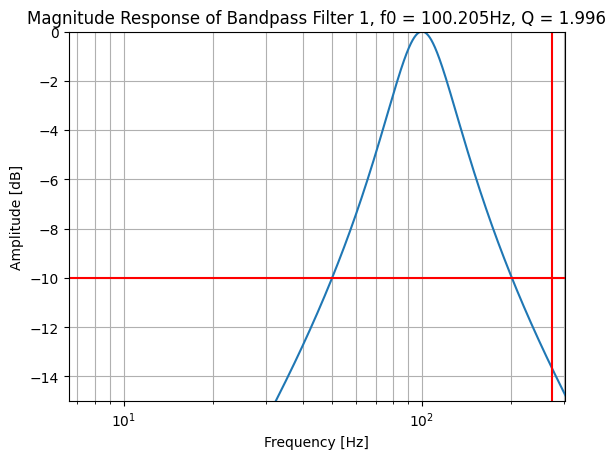

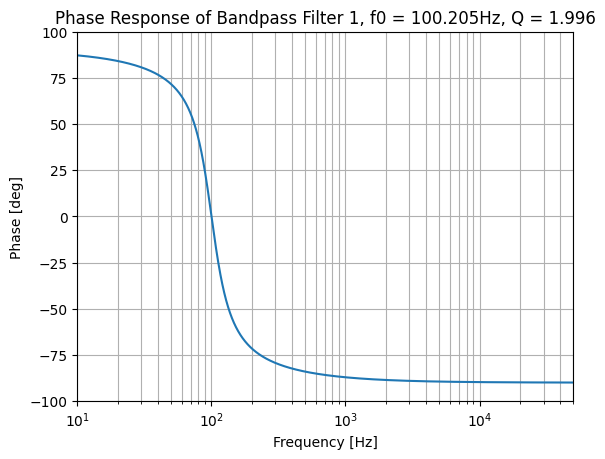

Component values: R3 = 231999.99999999997, R41 = 357.0, R42 = 6040.0, C = 1.5e-08, f0 = 275.420780565233, Q = 3.0111044550265635


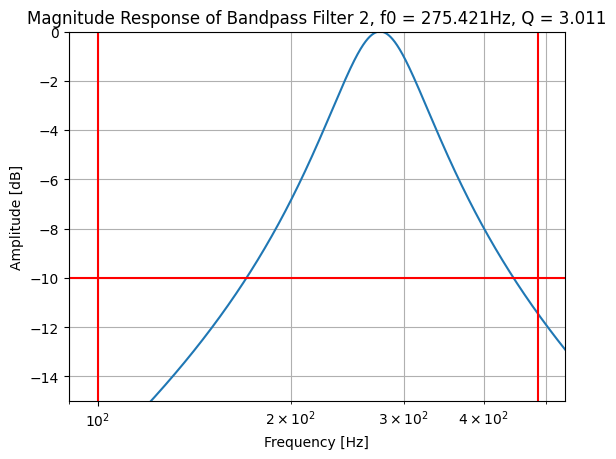

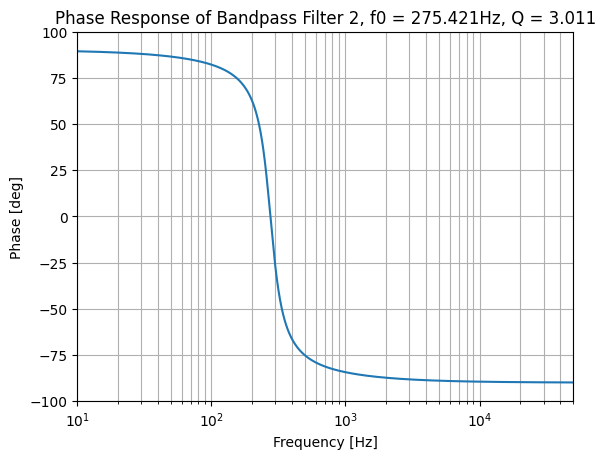

Component values: R3 = 174000.0, R41 = 84.5, R42 = 2670.0, C = 1.5e-08, f0 = 484.65518139250474, Q = 3.9739577007798643


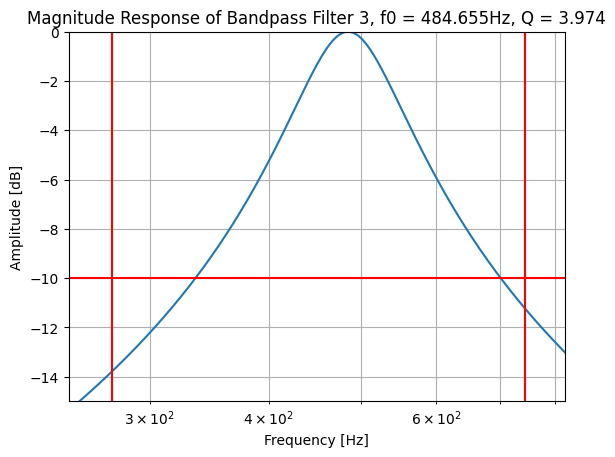

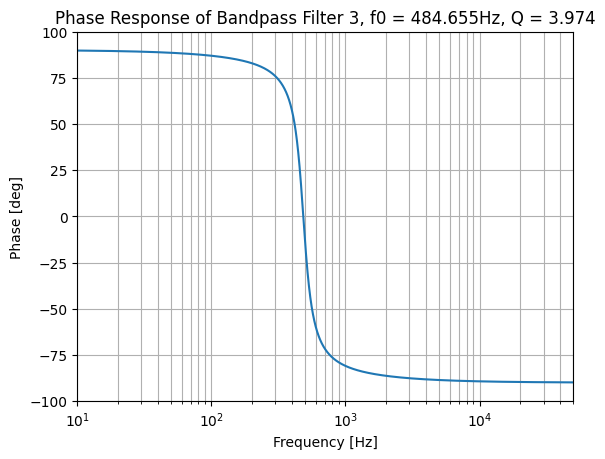

Component values: R3 = 261000.0, R41 = 52.300000000000004, R42 = 2550.0, C = 8.2e-09, f0 = 744.7445688148088, Q = 5.00739183845877


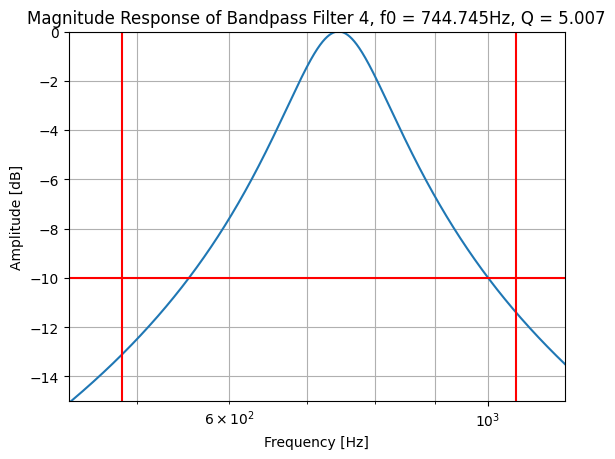

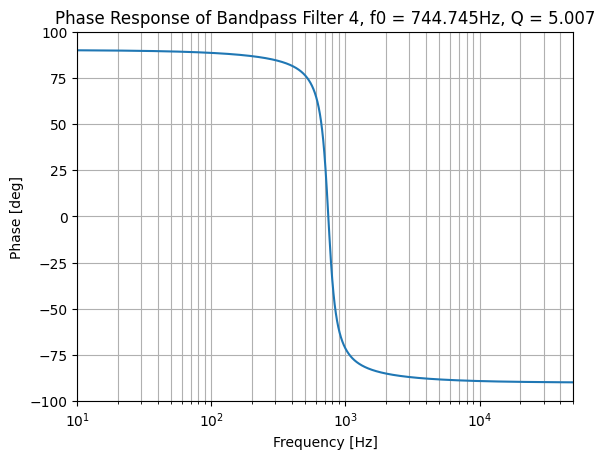

Component values: R3 = 324000.0, R41 = 63.4, R42 = 3160.0, C = 4.7e-09, f0 = 1047.8344379959708, Q = 5.01285807145477


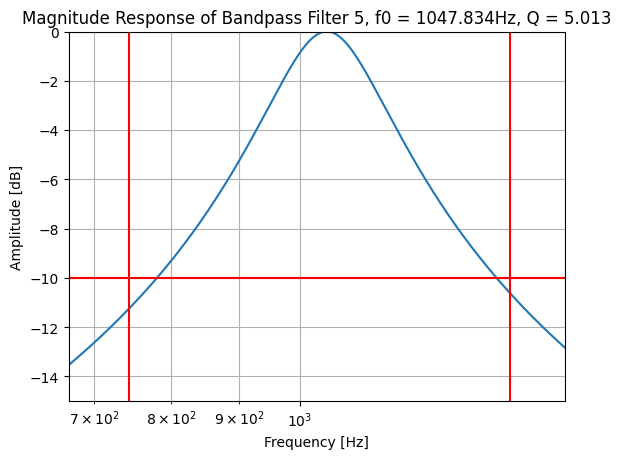

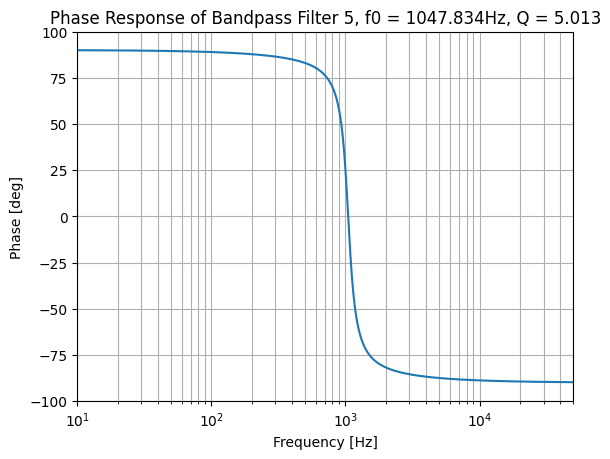

Component values: R3 = 280000.0, R41 = 27.400000000000002, R42 = 1910.0, C = 4.7e-09, f0 = 1453.8968992879868, Q = 6.010898192330235


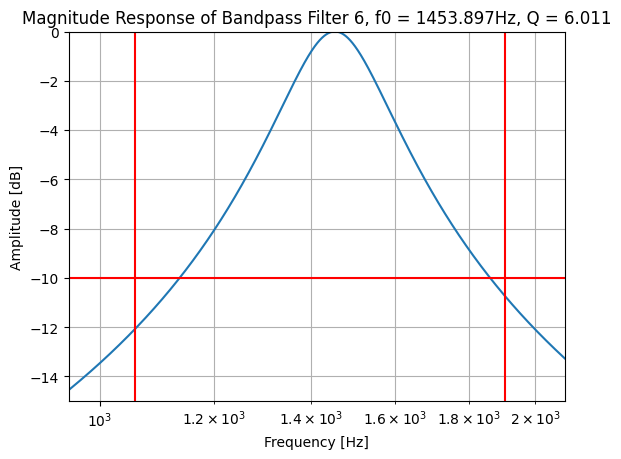

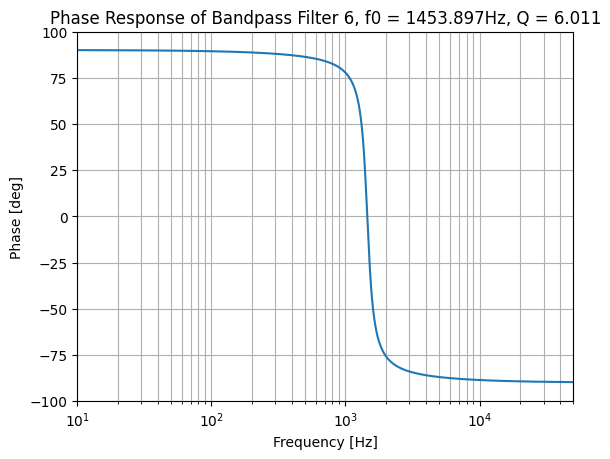

Component values: R3 = 215000.0, R41 = 20.5, R42 = 1470.0, C = 4.7e-09, f0 = 1891.6337482181766, Q = 6.005141484894938


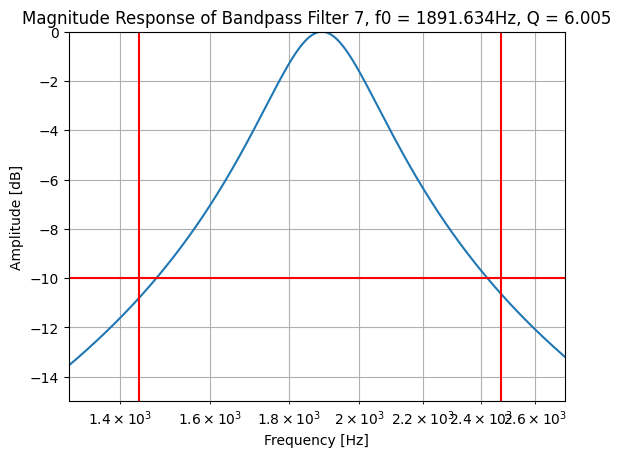

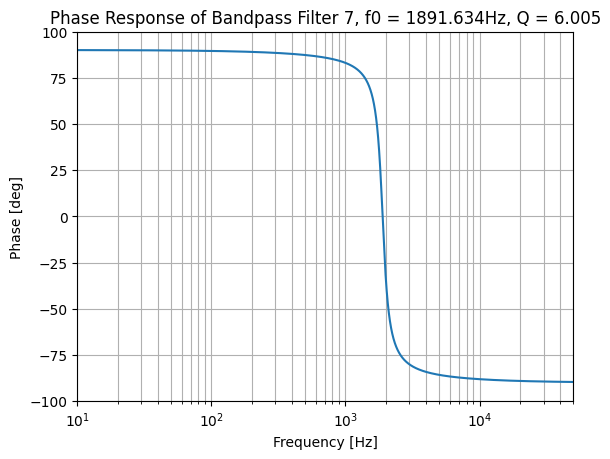

Component values: R3 = 750000.0, R41 = 39.2, R42 = 3830.0, C = 1.2e-09, f0 = 2462.054511962795, Q = 6.961295130767928


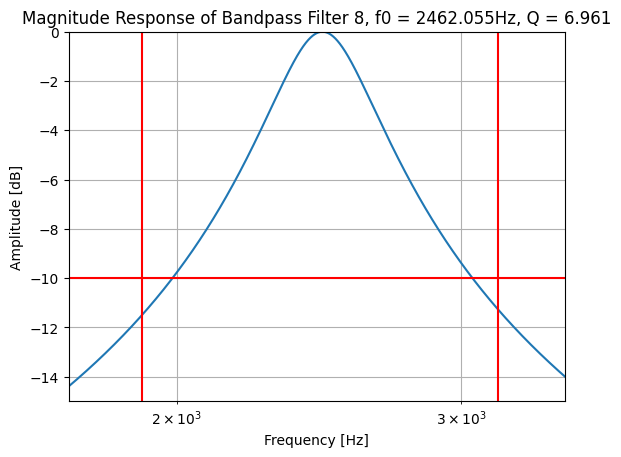

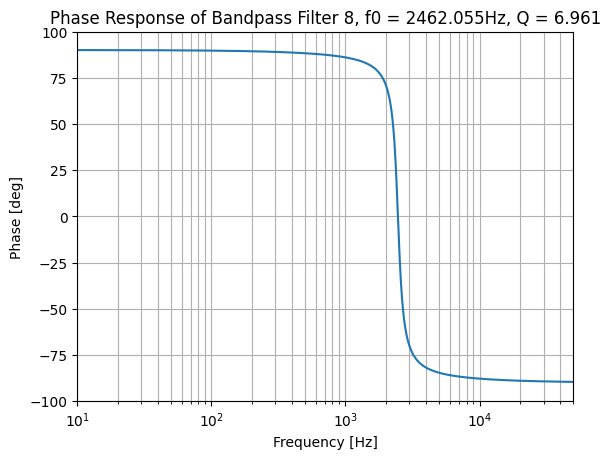

Component values: R3 = 590000.0, R41 = 30.9, R42 = 2940.0, C = 1.2e-09, f0 = 3167.8810272659057, Q = 7.0461517679951795


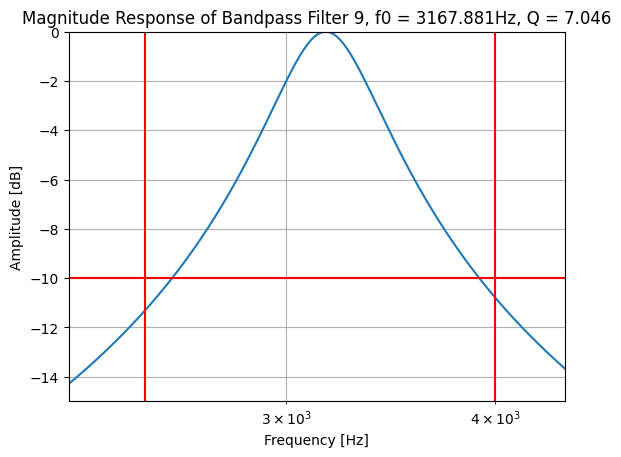

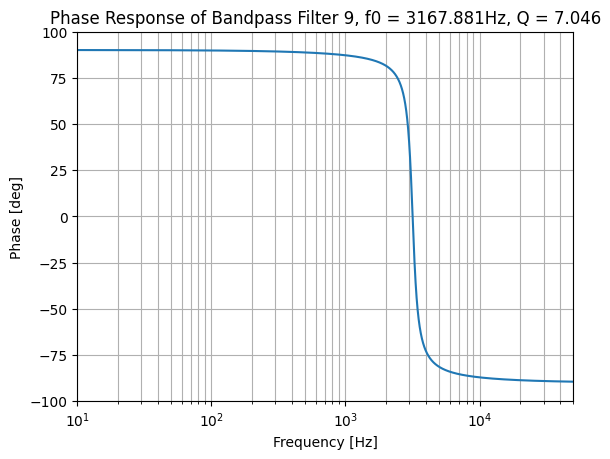

Component values: R3 = 562000.0, R41 = 28.700000000000003, R42 = 2800.0, C = 1e-09, f0 = 3991.705832765927, Q = 7.0476563103640375


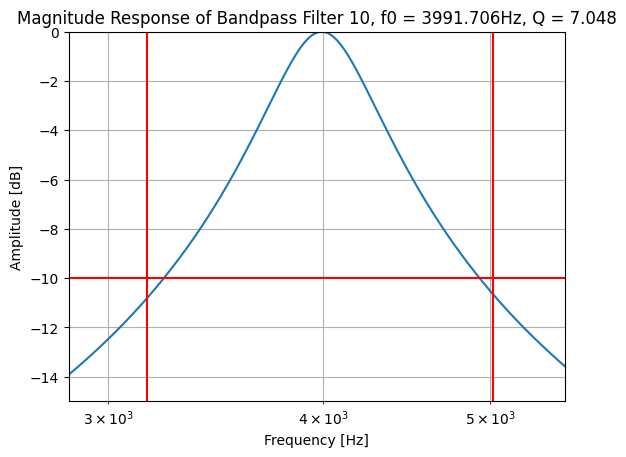

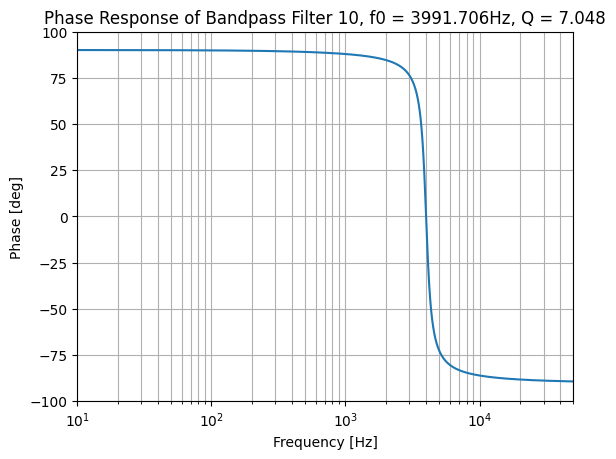

In [45]:
# get actual fiter data
for index in range(1, 11):
    R3 = df.loc[index - 1, 'R3']
    R41 = df.loc[index - 1, 'R41']
    R42 = df.loc[index - 1, 'R42']
    C = df.loc[index - 1, 'C']
    flower = df.loc[index - 1, 'fl, lower bandpass edge']
    fupper = df.loc[index - 1, 'fu, upper bandpass edge']
    # plot frequency response
    plotActualDesign(R3, R41, R42, C, flower, fupper, index)